In [3]:
from pymongo import MongoClient
from bson.objectid import ObjectId
from bson import json_util
from time import time
import datetime as dt
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz, process
import requests
from urllib.parse import unquote
import unidecode
import re
import requests
from bs4 import BeautifulSoup
import json
import pickle
import iso3166

In [4]:
class JSONEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, ObjectId):
            return str(o)
        return json.JSONEncoder.default(self, o)

In [5]:
client=MongoClient()
colombia=client["colombia_udea"]
openalex=client["openalex"]
doaj=client["doaj"]

In [16]:
def empty_source():
    return {
    "updated" : [],
	"names" : [],
    "abbreviations" : [],
	"types" : [],
	"keywords" : [],
    "languages" : [],
    "publisher" : "",
    "relations" : [],
    "addresses" : [],
    "external_ids" : [],
    "external_urls" : [],
    "review_processes" : [],
    "waiver" : {},
    "plagiarism_detection" : False,
    "open_access_start_year" : None,
    "publication_time_weeks" : None,
    "apc":{},
    "copyright" : {},
    "licenses" : [],
    "subjects" : [],
	"ranking" : []
}


### Inserting DOAJ db and scimago file

In [25]:
doaj=client["doaj"]
scimagojr=pd.read_csv("/current/data/scimagojr 2021.csv",sep=";",dtype={"Sourceid":str})
scienti=client["scienti_111"]

In [51]:
sources_inserted=[]

In [63]:
with client.start_session() as session:
    old=dt.datetime.now()
    for oldreg in doaj["stage"].find(no_cursor_timeout=True):
        #print(reg["_id"])
        if oldreg["_id"] in sources_inserted:
            continue
        reg=oldreg["bibjson"]
        entry = empty_source()
        entry["updated"]=[{"source":"doaj","time":int(time())}]
        entry["names"]=[{"lang":"en","name":reg["title"]}]
        entry["keywords"]=reg["keywords"]
        entry["languages"]=reg["language"]
        entry["publisher"]={"country_code":reg["publisher"]["country"],"name":reg["publisher"]["name"]}
        entry["open_access_start_year"]=reg["oa_start"] if "oa_start" in reg.keys() else None
        entry["external_urls"]=[{"source":ref,"url":url} for ref,url in reg["ref"].items()]
        entry["review_process"]=reg["editorial"]["review_process"]
        entry["plagiarism_detection"]=reg["plagiarism"]["detection"]
        entry["publication_time_weeks"]=reg["publication_time_weeks"]
        entry["copyright"]=reg["copyright"]
        entry["licenses"]=reg["license"]
        entry["addresses"]

        if "apc" in reg.keys():
            if reg["apc"]["has_apc"]:
                entry["apc"]={"charges":reg["apc"]["max"][-1]["price"],"currency":reg["apc"]["max"][-1]["currency"]}
        subjects_source={}
        if "subject" in reg.keys():
            if reg["subject"]:
                for sub in reg["subject"]:
                    sub_entry={
                        "id":"",
                        "name":sub["term"],
                        "external_ids":[{"source":sub["scheme"],"id":sub["code"]}]
                    }
                    if sub["scheme"] in subjects_source.keys():
                        subjects_source[sub["scheme"]].append(sub_entry)
                    else:
                        subjects_source[sub["scheme"]]=[sub_entry]
        for source,subs in subjects_source.items():
            entry["subjects"].append({
                "source":source,
                "subjects":subs
            })


        sjr=""
        found_sjr=False
        ids=[]
        if "eissn" in reg.keys():
            reg_db=colombia["sources"].find_one({"external_ids.id":reg["eissn"]})
            if reg_db:
                continue
            ids.append(reg["eissn"])
            entry["external_ids"].append({"source":"eissn","id":reg["eissn"]})
            sjr=scimagojr[[reg["eissn"].replace("-","") in sjreg["Issn"] for idx,sjreg in scimagojr.iterrows()]]
            if len(sjr)>0:
                found_sjr=True
        if "pissn" in reg.keys():
            reg_db=colombia["sources"].find_one({"external_ids.id":reg["pissn"]})
            if reg_db:
                continue
            ids.append(reg["pissn"])
            entry["external_ids"].append({"source":"pissn","id":reg["pissn"]})
            if found_sjr==False:
                sjr=scimagojr[[reg["pissn"].replace("-","") in sjreg["Issn"] for idx,sjreg in scimagojr.iterrows()]]
                if len(sjr)>0:
                    found_sjr=True
        if found_sjr:
            sjr=sjr.iloc[0]
            entry["updated"].append({"source":"scimago","time":int(time())})
            entry["external_ids"].append({"source":"scimago","id":str(sjr["Sourceid"])})
            entry["types"].append({"source":"scimago","type":sjr["Type"]})
            for extid in sjr["Issn"].split(","):
                extid=extid.strip()
                extid=extid[:4]+"-"+extid[4:]
                if not extid in ids:
                    entry["external_ids"].append({"source":"issn","id":extid})
            entry["ranking"].append({
                "to_date":1640995199,
                "from_date":1640995199,
                "rank":sjr["SJR Best Quartile"],
                "order":int(sjr["Rank"]) if sjr["Rank"] else None,
                "source":"scimago Best Quartile"
            })
            entry["ranking"].append({
                "to_date":1640995199,
                "from_date":1640995199,
                "rank":int(sjr["H index"]),
                "order":int(sjr["Rank"]) if sjr["Rank"] else None,
                "source":"scimago hindex"
            })
            if sjr["SJR"]:
                rank=""
                if isinstance(sjr["SJR"],str):
                    rank=float(sjr["SJR"].replace(",","."))
                else:
                    rank=sjr["SJR"]
                entry["ranking"].append({
                    "to_date":1640995199,
                    "from_date":1640995199,
                    "rank": rank,
                    "order":int(sjr["Rank"]) if sjr["Rank"] else None,
                    "source":"scimago"
                })
            scimago_subjects=[]
            for cat in sjr["Categories"].split(";"):
                scimago_subjects.append({
                    "id":"",
                    "name":cat.split(" (")[0],
                    "level":None,
                    "external_ids":[]
                })
            entry["subjects"].append({
                "source":"scimago",
                "subjects":scimago_subjects
            })
        found_scienti=False
        scienti_reg=None
        for idx in ids:
            scienti_reg=scienti["products"].find_one({"details.article.journal.TXT_ISSN_SEP":idx})
            if scienti_reg:
                found_scienti=True
                break
        if found_scienti:
            journal_reg=scienti_reg["details"][0]["article"][0]["journal"][0]
            entry["updated"].append({"source":"scienti","time":int(time())})
            entry["external_ids"].append({"source":"scienti","id":str(journal_reg["COD_REVISTA"])})
            if "TPO_REVISTA" in journal_reg.keys():
                entry["types"].append({"source":"scienti","type":journal_reg["TPO_REVISTA"]})
            if "TPO_CLASIFICACION" in journal_reg.keys():
                entry["ranking"].append({
                    "to_date":None,
                    "from_date":None,
                    "rank": journal_reg["TPO_CLASIFICACION"],
                    "order":None,
                    "source":"scienti"
                })
        
        colombia["sources"].insert_one(entry)
        sources_inserted.append(oldreg["_id"])
        delta=dt.datetime.now()-old
        if delta.seconds>240:
            print(len(sources_inserted))
            client.admin.command('refreshSessions', [session.session_id], session=session)
            old=dt.datetime.now()

In [64]:
#checking if there is some repeated issn
repeated_issn=[]
for source in colombia["sources"].find():
    issn=""
    for ext in source["external_ids"]:
        issn=ext["id"]
        count=colombia["sources"].count_documents({"external_ids.id":issn})
        if count>1:
            repeated_issn.append(issn)
            print("Repeated_issn: {} {} times".format(issn,count))
            for i in range(count-1):
                colombia["sources"].delete_one({"external_ids.id":issn})
            break

In [12]:
#adding the waiver variable in doaj
missing=0
with client.start_session() as session:
    old=dt.datetime.now()
    for reg in doaj["stage"].find():
        reg=reg["bibjson"]
        reg_db=None
        if "eissn" in reg.keys():
            reg_db=colombia["sources"].find_one({"external_ids.id":reg["eissn"]})
        if "pissn" in reg.keys():
            reg_db=colombia["sources"].find_one({"external_ids.id":reg["pissn"]})
        if reg_db:
            colombia["sources"].update_one({"_id":reg_db["_id"]},{"$set":{"waiver":reg["waiver"]}})
        else:
            missing+=1
        delta=dt.datetime.now()-old
        if delta.seconds>240:
            client.admin.command('refreshSessions', [session.session_id], session=session)
            old=dt.datetime.now()
print(missing)

1


In [17]:
#adding the empty variable for those registers that has no doaj equivalent
colombia["sources"].update_many({"waiver":{"$exists":0}},{"$set":{"waiver":{}}})

### Inserting from scimago if it is not on doaj

In [80]:
already_found=0
inserted=0
for issn_list in scimagojr["Issn"].unique():
    db_found=False
    ext_ids=[]
    for issn in issn_list.split(","):
        issn=issn.strip()
        extid=issn[:4]+"-"+issn[4:]
        db_reg=colombia["sources"].find_one({"external_ids.id":extid})
        if db_reg:
            db_found=True
            break
        ext_ids.append({"source":"issn","id":extid})
    if db_found:
        already_found+=1
        continue
    entry = empty_source()
    entry["updated"]=[{"source":"scimago","time":int(time())}]
    sjr=scimagojr[scimagojr["Issn"]==issn_list]
    sjr=sjr.iloc[0]
    entry["types"].append({"source":"scimago","type":sjr["Type"]})
    entry["external_ids"]=ext_ids
    entry["external_ids"].append({"source":"scimago","id":int(sjr["Sourceid"])})
    entry["names"]=[{"lang":"en","name":sjr["Title"]}]
    country=None
    try:
        if sjr["Country"]=="United States":
            sjr["Country"]="United States of America"
        elif sjr["Country"]=="United Kingdom":
            sjr["Country"]="United Kingdom of Great Britain and Northern Ireland"
        elif sjr["Country"]=="South Korea":
            sjr["Country"]="Korea, Republic of"
        elif sjr["Country"]=="Czech Republic":
            sjr["Country"]="Czechia"
        elif sjr["Country"]=="Taiwan":
            sjr["Country"]="Taiwan, Province of China"
        elif sjr["Country"]=="Iran":
            sjr["Country"]="Iran, Islamic Republic of"
        elif sjr["Country"]=="Moldova":
            sjr["Country"]="Moldova, Republic of"
        elif sjr["Country"]=="Venezuela":
            sjr["Country"]="Venezuela, Bolivarian Republic of"
        elif sjr["Country"]=="Macedonia":
            sjr["Country"]="North Macedonia"
        elif sjr["Country"]=="Palestine":
            sjr["Country"]="Palestine, State of"
        elif sjr["Country"]=="Tanzania":
            sjr["Country"]="Tanzania, United Republic of"
            
        country=iso3166.countries_by_name.get(sjr["Country"].upper()).alpha2
    except Exception as e:
        print(e)
        print(sjr["Country"])
    if country:
        entry["publisher"]={"country_code":country,"name":sjr["Publisher"]}
    entry["ranking"].append({
        "to_date":1640995199,
        "from_date":1640995199,
        "rank":sjr["SJR Best Quartile"],
        "order":int(sjr["Rank"]) if sjr["Rank"] else None,
        "source":"Scimago Best Quartile"
    })
    entry["ranking"].append({
        "to_date":1640995199,
        "from_date":1640995199,
        "rank":int(sjr["H index"]),
        "order":int(sjr["Rank"]) if sjr["Rank"] else None,
        "source":"Scimago hindex"
    })
    if sjr["SJR"]:
        rank=""
        if isinstance(sjr["SJR"],str):
            rank=float(sjr["SJR"].replace(",","."))
        else:
            rank=sjr["SJR"]
        entry["ranking"].append({
            "to_date":1640995199,
            "from_date":1640995199,
            "rank": rank,
            "order":int(sjr["Rank"]) if sjr["Rank"] else None,
            "source":"Scimago"
        })
    scimago_subjects=[]
    for cat in sjr["Categories"].split(";"):
        scimago_subjects.append({
            "id":"",
            "name":cat.split(" (")[0],
            "level":None,
            "external_ids":[]
        })
    entry["subjects"].append({
        "source":"Scimago",
        "subjects":scimago_subjects
    })
    #print(entry)
    #break
    colombia["sources"].insert_one(entry)
    inserted+=1
print(already_found,inserted)

'NoneType' object has no attribute 'alpha2'
Vatican City State
5972 21333


### Inserting sources from scienti

In [86]:
in_doaj=0
in_scimago=0
in_doaj_scimago=0
in_scienti=0
in_scienti_doaj=0
in_scienti_scimago=0
in_scienti_scimago_doaj=0
for reg in colombia["sources"].find():
    sources=[]
    for up in reg["updated"]:
        sources.append(up["source"])
    if "scimago" in sources and "doaj" in sources:
        in_doaj_scimago+=1
    if "scimago" in sources and not "doaj" in sources:
        in_scimago+=1
    if "doaj" in sources and not "scimago" in sources:
        in_doaj+=1
for issn in scienti["products"].distinct("details.article.journal.TXT_ISSN_REF_SEP"):
    #print(issn)
    sources=["scienti"]
    reg=colombia["sources"].find_one({"external_ids.id":issn})
    if reg:
        for up in reg["updated"]:
            sources.append(up["source"])
        if "scimago" in sources and "doaj" in sources:
            in_scienti_scimago_doaj+=1
        if "scimago" in sources:
            in_scienti_scimago+=1
        if "doaj" in sources:
            in_scienti_doaj+=1
    else:
        in_scienti+=1
print(in_doaj,in_scimago,in_doaj_scimago,in_scienti)

12502 21333 5967 596


In [90]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

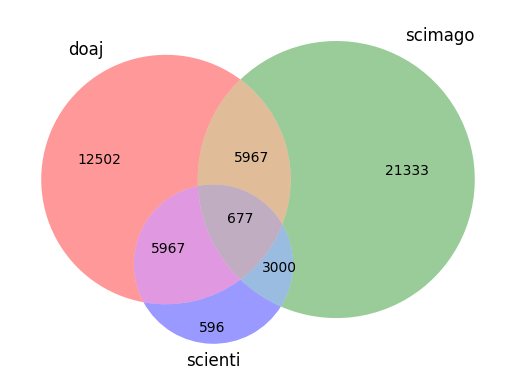

In [92]:
def venn_diagram(a, b, c, labels=['doaj', 'scimago', 'scienti']):

    a = set(a)
    b = set(b)
    c = set(c)

    only_a = in_doaj
    only_b = in_scimago
    only_c = in_scienti

    only_a_b = in_doaj_scimago
    only_a_c = in_doaj_scimago
    only_b_c = in_scienti_scimago

    a_b_c = in_scienti_scimago_doaj

    venn3(subsets=(only_a, only_b, only_a_b, only_c, only_a_c, only_b_c, a_b_c), set_labels=labels)

a, b, c = np.round(np.random.rand(3, 50000), 5)
venn_diagram(a, b, c)

### Inserting sources from openalex

In [4]:
for source in openalex["venues"].find():
    print(source)
    break

{'_id': ObjectId('63c6ff77e4cc32ff5aef2fed'), 'id': 'https://openalex.org/V4306480745', 'issn_l': None, 'issn': None, 'display_name': 'The Moreton Bay Foundation eBooks', 'publisher': 'The Moreton Bay Foundation', 'works_count': 17, 'cited_by_count': 0, 'is_oa': None, 'is_in_doaj': None, 'alternate_titles': [], 'abbreviated_title': None, 'homepage_url': None, 'country_code': None, 'ids': {'openalex': 'https://openalex.org/V4306480745'}, 'type': 'ebook platform', 'apc_usd': None, 'societies': [], 'counts_by_year': [{'year': 2019, 'works_count': 17, 'cited_by_count': 0}], 'x_concepts': [{'id': 'https://openalex.org/C86803240', 'wikidata': 'https://www.wikidata.org/wiki/Q420', 'display_name': 'Biology', 'level': 0, 'score': 100.0}, {'id': 'https://openalex.org/C205649164', 'wikidata': 'https://www.wikidata.org/wiki/Q1071', 'display_name': 'Geography', 'level': 0, 'score': 100.0}, {'id': 'https://openalex.org/C95457728', 'wikidata': 'https://www.wikidata.org/wiki/Q309', 'display_name': 'Hi